## GCM Filters on Irregular Grids with Irregular Filter Scale 

This notebook will use data from the idealized one-basin NeverWorld2 configuration performed in MOM6.

We will filter data which is on an irregular grid (hozirontal grid spacing dx varies with latitude, dy is constant).

## Handling various model resolutions

We define one spatial filter based on the 1/4 degree grid.

We then read in higher-resolution data and coarsen the fields that we're filtering using xarray.Dataset.coarsen onto the 1/4 degree grid.

We then perform the filtering and interpolate the filtered field back onto the high-resolution grid.

In [1]:
%reset
import gcm_filters
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import cmocean
from xgcm import Grid
print('done')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


done


### Execute the following cell to read in NW2 data for 1/4 (run 20) degree 

In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree 
fs025=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
av025     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
Nx = np.size(av025.xh)
xhp = av025.xh
Ny = np.size(av025.yh)
yhp = av025.yh
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 240, Ny = 560


### To filter with fixed filter length scale, we will use the grid type: IRREGULAR_CARTESIAN_WITH_LAND, and its associated Laplacian. The Laplacian needs the following grid variables:

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)


['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In [5]:
wet_mask = fs025.wet
area = fs025.area_t

# Grid define for computations 
grid = Grid(av025, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'}});
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center

For the remaining grid variables, recall the following conventions:

dxw = x-spacing centered at western cell edge

dyw = y-spacing centered at western cell edge

dxs = x-spacing centered at southern cell edge

dys = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [6]:
dxw = xr.DataArray(data=fs025.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=fs025.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=fs025.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=fs025.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))

In [7]:
print('our filter scale is set by a function related to the deformation radius')
Ld = xr.DataArray(av025.Rd1.mean(dim='time'))
Ld = Ld.fillna(np.nanmax(Ld))
Ld[0:60,:]=Ld[60,:].mean('xh')
Ld[500:560,:]=Ld[500,:].mean('xh')

#Defining filter scale to be 5 times deformation radius, except near the equator where it is set to 500km.
fscale = (Ld.mean('xh'))*5; fscale[200:360]=500000.
fscale = 0.*Ld+fscale

print(np.nanmin(Ld),np.nanmax(Ld))
print(Ld)

our filter scale is set by a function related to the deformation radius
234.31934 445500.75
<xarray.DataArray 'Rd1' (yh: 560, xh: 240)>
array([[20879.006, 20879.006, 20879.006, ..., 20879.006, 20879.006,
        20879.006],
       [20879.006, 20879.006, 20879.006, ..., 20879.006, 20879.006,
        20879.006],
       [20879.006, 20879.006, 20879.006, ..., 20879.006, 20879.006,
        20879.006],
       ...,
       [39682.824, 39682.824, 39682.824, ..., 39682.824, 39682.824,
        39682.824],
       [39682.824, 39682.824, 39682.824, ..., 39682.824, 39682.824,
        39682.824],
       [39682.824, 39682.824, 39682.824, ..., 39682.824, 39682.824,
        39682.824]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88


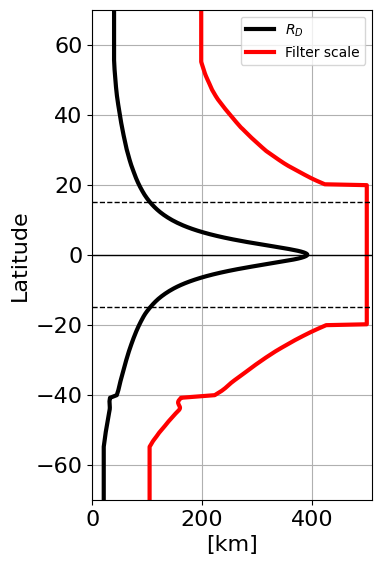

In [8]:
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.7,0.7]) 

ax1.set_xlabel('[km]',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

ax1.plot(Ld.mean('xh')/1000,yhp,'k',linewidth=3)
ax1.plot(fscale.mean('xh')/1000,yhp,'r',linewidth=3)

ax1.plot([0,1000],[0,0],'k',linewidth=1)
ax1.plot([0,1000],[15,15],'--k',linewidth=1)
ax1.plot([0,1000],[-15,-15],'--k',linewidth=1)


ax1.set_xlim([0,510])
ax1.set_ylim([-70,70])
ax1.grid('on')

plt.legend(['$R_D$','Filter scale'])
plt.show()

### The filter needs to know what the minimum grid spacing is in our model.

In [9]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())

dx_min = dx_min.values
dx_max = dx_max.values
dx_min, dx_max

(array(9518.17259783), array(27829.27492305))

### Setting the filter scale:

In [10]:
#Option 1 using fixed filter scale:

# filter_scale = 500000
# kappa_w = Ld*0.+1. #using kappa_w and kappa_s = 1s recovers the fixed filter scale.
# kappa_s = Ld*0.+1.

#Option 2 using local deformation radius as the filter scale:

# Lf = np.max(Ld.data)
# filter_scale = Lf*10
# kappa_w = Ld**2 / Lf**2
# kappa_s = Ld**2 / Lf**2

#Option 3: using filter scale that's a function of zonally averaged Ld*5, 500km near equator
Lf = np.max(fscale.data)
filter_scale = Lf
kappa_w = fscale**2 / Lf**2
kappa_s = fscale**2 / Lf**2

### Plotting the filter scale:

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


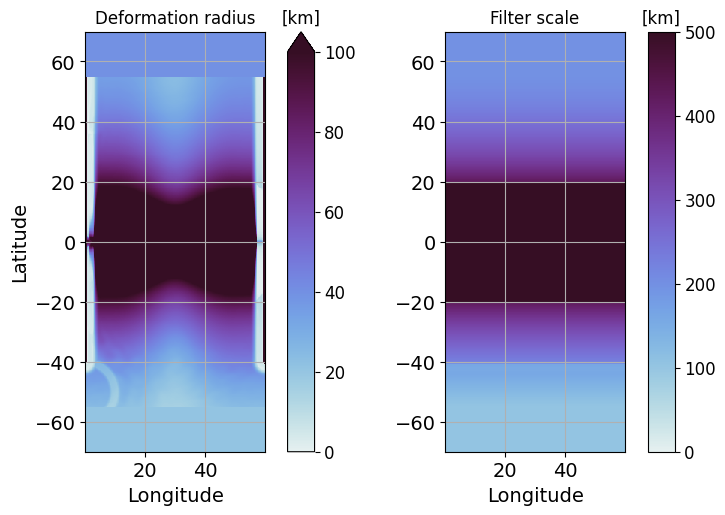

In [11]:
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.35,0.7]) 
axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.55,0.2,0.35,0.7]) 
axc2 = fig.add_axes([.85, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Deformation radius',fontsize=12)
ax2.set_title('Filter scale',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


plotted1 =ax1.pcolormesh(xhp,yhp,Ld/1000,cmap=cmocean.cm.dense,vmin=0,vmax=100)
plotted2 =ax2.pcolormesh(xhp,yhp,filter_scale*(kappa_s**0.5)/1000,cmap=cmocean.cm.dense,vmin=0,vmax=500)


ax1.set_aspect('equal', 'box'); ax2.set_aspect('equal', 'box')
ax1.grid('on'); ax2.grid('on')

cbar1 = plt.colorbar(mappable=plotted1, cax=axc1, orientation = 'vertical',extend='max');
cbar2 = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');

cbar1.ax.tick_params(labelsize=12); cbar2.ax.tick_params(labelsize=12);
axc1.set_title('[km]'); axc2.set_title('[km]')

#
plt.show()

### Defining the filter:

In [13]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=70, #0 is default
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

n_steps = 70


Filter(filter_scale=500000.0, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=70, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

### Now we read in the high-resolution data set to be filtered.

In [14]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/

run=20; cfac=1 #Can do the same process for 1/4 degree but the coarsening will have no effect since it's on the same grid.
#run=26; cfac=2 #1/8 degree
#run=28; cfac=4 #1/16 degree

fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

#For 1/32 degree:

# %cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
# run=33; cfac=8 #1/32 degree NeverWorld setup
# fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
# av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# # print(av)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


### Interpolating the velocities onto thickness points and coarsening to 0.25 degree grid:

In [15]:
%%time

# Grid define for computations 
gridhr = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
xhhr = av.xh
yhhr = av.yh

ufull = av.u[:,:,:,:]; 
u_interp= gridhr.interp(ufull,axis='X').fillna(0.) #interpolating onto thickness points

vfull = av.v[:,:,:,:];
v_interp=gridhr.interp(vfull,axis='Y').fillna(0.) #interpolating onto thickness points

h = (av.h[:,:,:,:]).mean(dim='time').fillna(0.)
depth=fs.depth_ocean.fillna(0.)

u_interp_coarse = u_interp.coarsen(xh=cfac,yh=cfac, boundary="exact").mean() #coarsening
v_interp_coarse = v_interp.coarsen(xh=cfac,yh=cfac, boundary="exact").mean() #coarsening
print(u_interp_coarse.shape)

(100, 15, 560, 240)
CPU times: user 7.5 s, sys: 5.64 s, total: 13.1 s
Wall time: 52.3 s


### Defining the regridder that will place our coarsened and filtered data back onto the high resolution grid

In [16]:
%%time
ds_for_regridder = u_interp_coarse[0,:,:,:]
#Define regridder
ds_out = xr.Dataset({'lat': (['lat'], yhhr),
                     'lon': (['lon'], xhhr),
                    }
                   )
ds = ds_for_regridder.rename({'xh': 'lon', 'yh': 'lat'})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder


Create weight file: bilinear_560x240_560x240.nc
Remove file bilinear_560x240_560x240.nc
CPU times: user 3.81 s, sys: 571 ms, total: 4.39 s
Wall time: 5.3 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_560x240_560x240.nc 
Reuse pre-computed weights? False 
Input grid shape:           (560, 240) 
Output grid shape:          (560, 240) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [ ]:
%%time
print('Filtering on coarse grid, interpolating filtered field back onto high resolution grid')
#Initialize zero arrays for the mean velocity components:
u_mean=xr.zeros_like(u_interp); 
v_mean=xr.zeros_like(v_interp); 
#u_interp and v_interp are the unfiltered velocities

for i in range(0,100): #100 5-day averages, so total 500 day span
    #filtering on low res grid
    u_mean_lr = (filter.apply(u_interp_coarse[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field
    v_mean_lr = (filter.apply(v_interp_coarse[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field
    #Placing back on the high-resolution grid:
    u_mean[i,:,:,:] = regridder(u_mean_lr);                                           
    v_mean[i,:,:,:] = regridder(v_mean_lr);
    print(i)


Filtering on coarse grid, interpolating filtered field back onto high resolution grid


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [ ]:
h.shape

### Now we compute the eddy components and then the KE corresponding to mean/eddy/BT/BC parts.

In [ ]:
#We will remove the stationary part of the small scale flow and add it to the mean:
u_eddy = (u_interp-u_mean).fillna(0.); 
stationary_small_u = u_eddy.mean('time')
u_eddy = u_eddy-stationary_small_u
u_mean = u_mean+stationary_small_u

v_eddy = (v_interp-v_mean).fillna(0.); 
stationary_small_v = v_eddy.mean('time')
v_eddy = v_eddy-stationary_small_v
v_mean = v_mean+stationary_small_v


#Splitting into Barotropic (BT) and Baroclinic (BC)
u_BT_mean = (u_mean*h/depth).sum('zl')
u_BC_mean = (u_mean-u_BT_mean)                         
v_BT_mean = (v_mean*h/depth).sum('zl')
v_BC_mean = (v_mean-v_BT_mean)

u_BT_eddy = (u_eddy*h/depth).sum('zl')
u_BC_eddy = (u_eddy-u_BT_eddy)
v_BT_eddy = (v_eddy*h/depth).sum('zl')
v_BC_eddy = (v_eddy-v_BT_eddy)
        

#Computing Kinetic Energy components:
KE_BT_eddy = 0.5*(u_BT_eddy**2+v_BT_eddy**2)
KE_BC_eddy = (0.5*(u_BC_eddy**2+v_BC_eddy**2)*h/depth).sum('zl')

KE_BT_mean = 0.5*(u_BT_mean**2+v_BT_mean**2)  #
KE_BC_mean = (0.5*(u_BC_mean**2+v_BC_mean**2)*h/depth).sum('zl')  #
    
#Totals:
KE_mean = KE_BT_mean+KE_BC_mean; 
KE_eddy = KE_BT_eddy+KE_BC_eddy; 
KE_BT   = KE_BT_mean+KE_BT_eddy
KE_BC   = KE_BC_mean+KE_BC_eddy

KE_TOT = KE_BT+KE_BC #same as summing KE_mean and KE_eddy, just summing the 4 KE components

print('Done, but KE values still need to be averaged in time')


In [ ]:
#For computing residuals/errors:
KE_raw = (0.5*(u_interp**2+v_interp**2)*h/depth).sum('zl') #compare to KE_TOT
KE_eddy_RAW = (0.5*(u_eddy**2+v_eddy**2)*h/depth).sum('zl') #compare to 
KE_mean_RAW = (0.5*(u_mean**2+v_mean**2)*h/depth).sum('zl')
u_BT_raw = (u_interp*h/depth).sum('zl'); u_BC_raw = u_interp-u_BT_raw
v_BT_raw = (v_interp*h/depth).sum('zl'); v_BC_raw = v_interp-v_BT_raw
KE_BT_RAW= 0.5*(u_BT_raw**2+v_BT_raw**2)
KE_BC_RAW= (0.5*(u_BC_raw**2+v_BC_raw**2)*h/depth).sum('zl')

#error associated with mean eddy decomposition:
KE_meaneddy_error=KE_raw - (KE_mean_RAW+KE_eddy_RAW)

#error associated with BTBC decomposition on the total field, and on the eddy and mean fields:
KE_BTBC_error = KE_raw - (KE_BT_RAW+KE_BC_RAW)
KE_eddy_error = KE_eddy_RAW-(KE_BT_eddy+KE_BC_eddy)
KE_mean_error = KE_mean_RAW-(KE_BT_eddy+KE_BC_eddy)
print('done!')

In [ ]:
KE_BC_RAW.shape

In [ ]:

#Plotting eddy/mean velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.25,0.7]) 
axc1 = fig.add_axes([0.4,0.2,0.03,0.7])
ax2 = fig.add_axes([0.55,0.2,0.25,0.7]) 
axc2 = fig.add_axes([.8, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Raw Total KE',fontsize=14)
ax2.set_title('Raw Total KE - (Mean+Eddy KE)',fontsize=9)

plotted1 =ax1.pcolorfast(xhhr,yhhr,(KE_raw).mean('time'),cmap=cmocean.cm.curl,vmin=-.025,vmax=.025)
plotted2 =ax2.pcolorfast(xhhr,yhhr,(KE_raw-(KE_eddy_RAW+KE_mean_RAW)).mean('time'),cmap=cmocean.cm.curl,vmin=-.025,vmax=.025)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted1, cax=axc1, orientation = 'vertical').ax.tick_params(labelsize=12);
cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical').ax.tick_params(labelsize=12);

# # #
# plt.clf()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


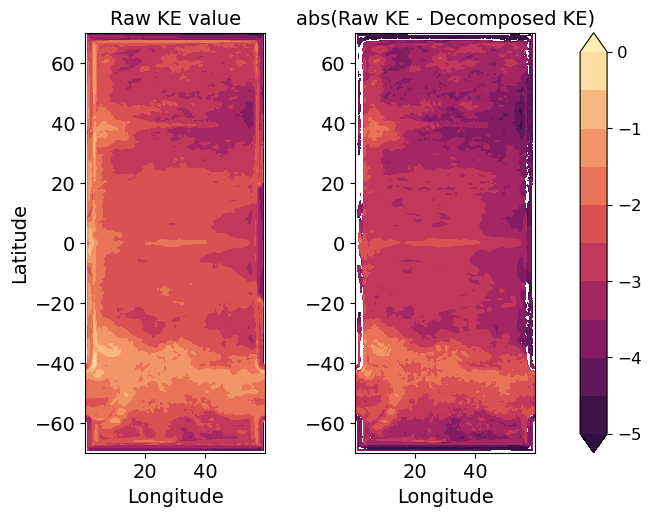

In [22]:

#Plotting eddy/mean velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Raw KE value',fontsize=14)
ax2.set_title('abs(Raw KE - Decomposed KE)',fontsize=14)

levels=np.linspace(-5,0,11)

plotted1 =ax1.contourf(xhhr,yhhr,np.log10(KE_unfiltered.mean('time')),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
plotted2 =ax2.contourf(xhhr,yhhr,np.log10((KE_unfiltered-KE_total).mean('time')),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
# # #
# plt.clf()

### Plotting results:

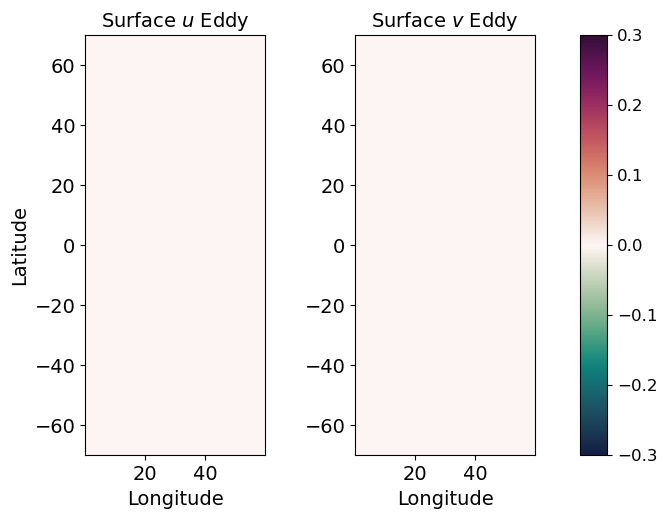

In [20]:

#Plotting eddy/mean velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Surface $u$ Eddy',fontsize=14)
ax2.set_title('Surface $v$ Eddy',fontsize=14)

plotted1 =ax1.pcolorfast(xhhr,yhhr,u_eddy[:,0,:,:].mean('time'),cmap=cmocean.cm.curl,vmin=-.3,vmax=.3)
plotted2 =ax2.pcolorfast(xhhr,yhhr,v_eddy[:,0,:,:].mean('time'),cmap=cmocean.cm.curl,vmin=-.3,vmax=.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
# # #
# plt.clf()

Text(0.5, 1.0, '[1/s]')

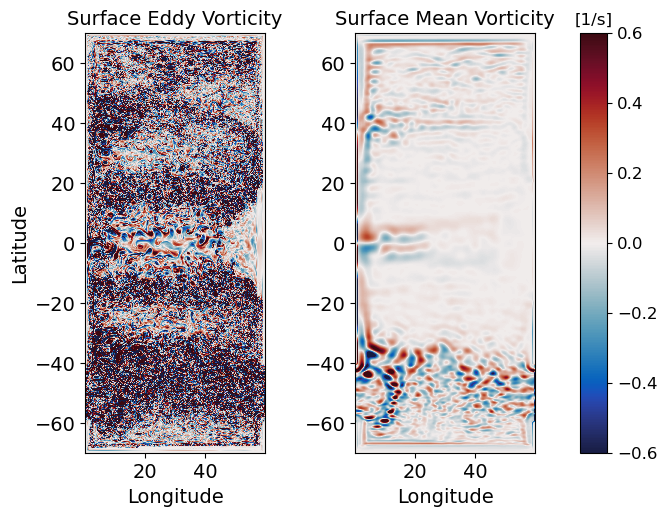

In [26]:
#Plotting eddy/mean vorticities
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Surface Eddy Vorticity',fontsize=14)
ax2.set_title('Surface Mean Vorticity',fontsize=14)

eddy_vorticity_sn = (v_eddy[-1,0,:,:]).differentiate('xh')-(u_eddy[-1,0,:,:]).differentiate('yh')
eddy_vorticity_m = ((v_eddy[:,0,:,:]).differentiate('xh')-(u_eddy[:,0,:,:]).differentiate('yh')).mean('time')

mean_vorticity = ((v_mean[:,0,:,:]).differentiate('xh')-(u_mean[:,0,:,:]).differentiate('yh')).mean('time')

plotted1 =ax1.pcolorfast(xhhr,yhhr,eddy_vorticity_sn,cmap=cmocean.cm.balance,vmin=-.6,vmax=.6)
plotted2 =ax2.pcolorfast(xhhr,yhhr,mean_vorticity,cmap=cmocean.cm.balance,vmin=-.6,vmax=.6)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
cbar.ax.set_title('[1/s]')
# # #
# plt.clf()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


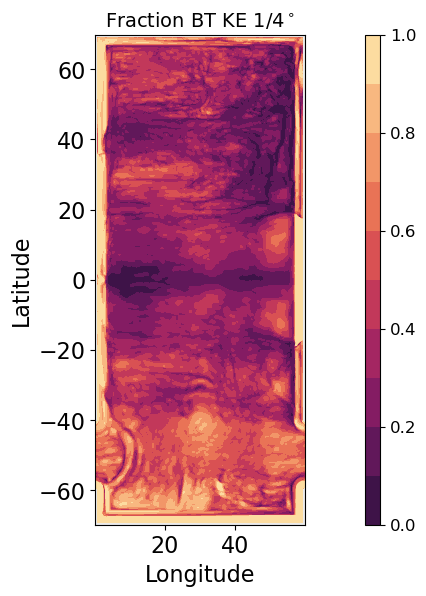

In [48]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(0,1.,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
var = (KE_BT/(KE_BT+KE_BC)).mean('time')
ax1.set_title('Fraction BT KE $1/4^\circ$',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhhr,yhhr,var,levels=levels,cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

Text(0.5, 1.0, '1/4$^\\circ$ KE Fractions')

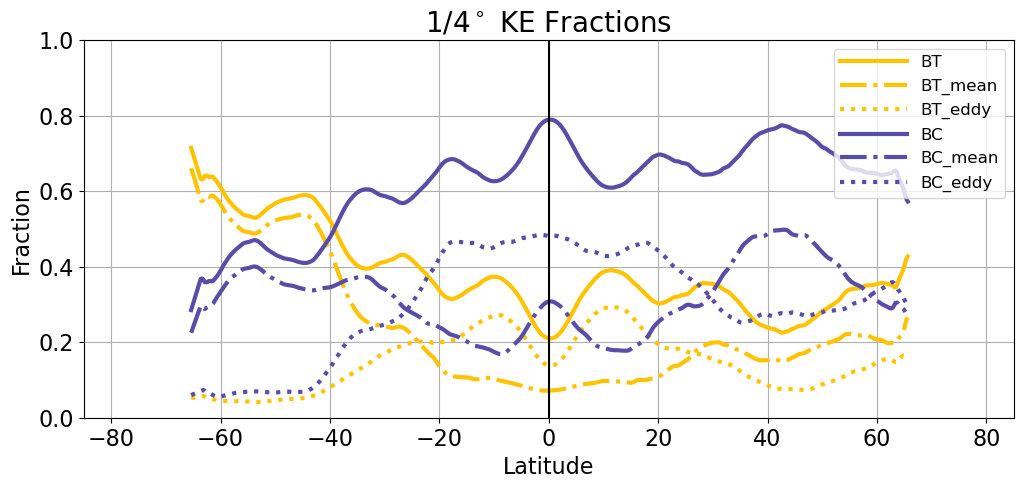

In [90]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh_003125,np.convolve((fraction_BT_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BT_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh_003125,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BC_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BC_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT mean','BT eddy','BC','BC mean','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions',fontsize=20)

In [ ]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BT_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh_025,np.convolve((fraction_BT_mean_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BT_eddy_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh_025,np.convolve((fraction_BC_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BC_mean_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BC_eddy_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT mean','BT eddy','BC','BC mean','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/4$^\circ$ KE Fractions',fontsize=20)

In [17]:
xh025  = xhhr
yh025  = yhhr
print('done')

done


In [28]:
Bar025 = KE_BT/(KE_BT+KE_BC)
KE_eddy025=KE_eddy
KE_mean025=KE_mean
KE_TOT025=KE_TOT
xh025  = xhhr
yh025  = yhhr


In [21]:
Bar00625 = (KE_BT/(KE_BT+KE_BC)).coarsen(xh=cfac,yh=cfac, boundary="exact").mean()
KE_eddy00625=KE_eddy.coarsen(xh=cfac,yh=cfac, boundary="exact").mean()
KE_mean00625=KE_mean.coarsen(xh=cfac,yh=cfac, boundary="exact").mean()
KE_TOT00625=KE_TOT.coarsen(xh=cfac,yh=cfac, boundary="exact").mean()

Bar00625.shape


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(100, 560, 240)

In [33]:
from scipy.io import savemat
savemat("025deg_comparison.mat", {"Bar025": Bar025,"KE_eddy025":KE_eddy025,"KE_mean025":KE_mean025, "KE_TOT025":KE_TOT025})
savemat("00625deg_comparison.mat", {"Bar00625": Bar00625,"KE_eddy00625":KE_eddy00625,"KE_mean00625":KE_mean00625, "KE_TOT00625":KE_TOT00625})

In [29]:
# from scipy.io import loadmat
# mat025=loadmat('025deg_comparison.mat')
# mat00625=loadmat('00625deg_comparison.mat')
# print(mat025)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


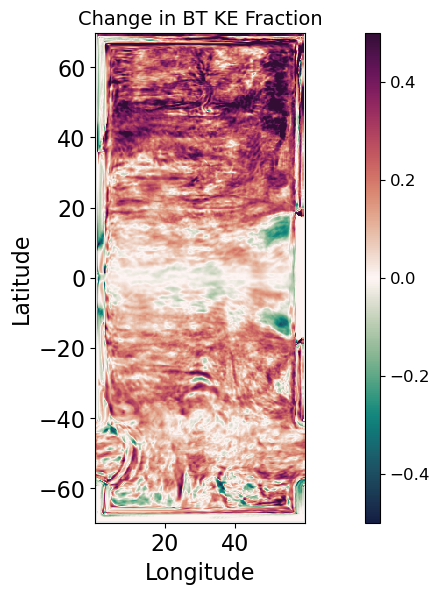

In [30]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)



#ax1.set_title('Surface KE Unfiltered',fontsize=14)
var = Bar00625.mean('time')-Bar025.mean('time')
ax1.set_title('Change in BT KE Fraction',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.pcolor(xhhr,yhhr,var,cmap=cmocean.cm.curl,vmin=-.5,vmax=.5)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

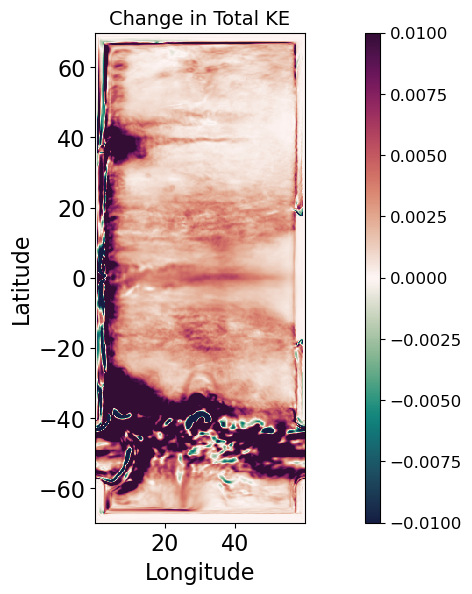

In [107]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


#ax1.set_title('Surface KE Unfiltered',fontsize=14)
var = ((KE_TOT00625-KE_TOT025).mean('time'))
ax1.set_title('Change in Total KE',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.pcolor(xhhr,yhhr,var,vmin=-0.01,vmax=0.01,cmap=cmocean.cm.curl)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

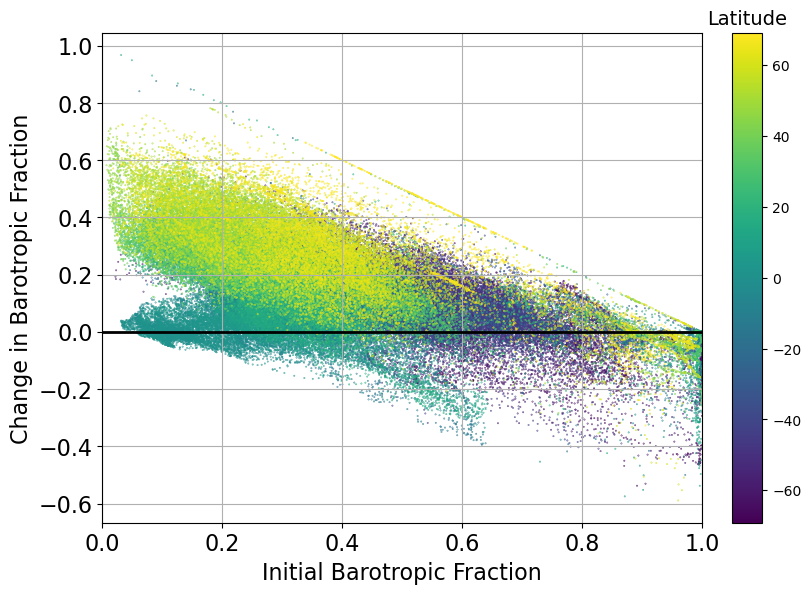

In [31]:
fig = plt.figure(figsize=(10, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])

ax1.set_xlabel('Initial Barotropic Fraction',fontsize=16)
ax1.set_ylabel('Change in Barotropic Fraction',fontsize=16)
ax1.tick_params(labelsize=16); 


#ax1.set_title('Surface KE Unfiltered',fontsize=14)
initial = (Bar025).mean('time')
#final = (Bar00625).mean('time')
change = (Bar00625-Bar025).mean('time')
ax2.set_title('Latitude',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.scatter(initial,change,c=fs.geolat,s=.1)
ax1.plot([0,1],[0,0],'k',linewidth=2)
ax1.set_xlim([0,1.])
ax1.grid()
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
plt.show()

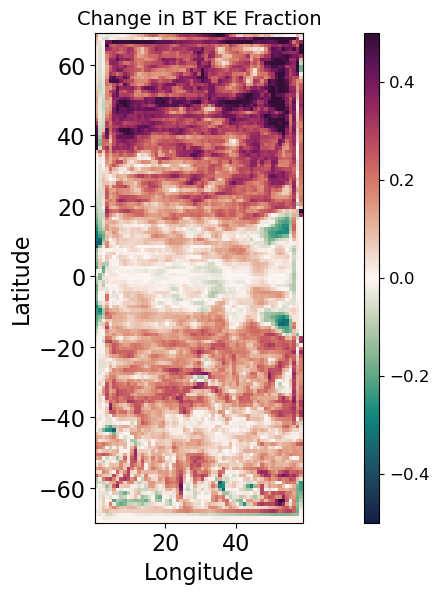

In [65]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)



#ax1.set_title('Surface KE Unfiltered',fontsize=14)
var = (Bar00625.mean('time')-Bar025.mean('time')).coarsen(xh=4,yh=4, boundary="exact").mean()
ax1.set_title('Change in BT KE Fraction',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.pcolor(xhhr[::4],yhhr[::4],var,cmap=cmocean.cm.curl,vmin=-.5,vmax=.5)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

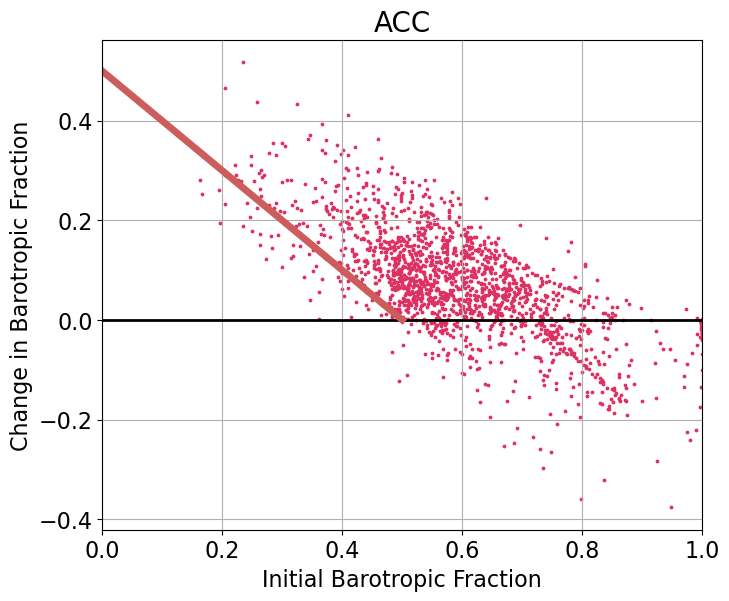

In [64]:
fig = plt.figure(figsize=(10, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 

ax1.set_xlabel('Initial Barotropic Fraction',fontsize=16)
ax1.set_ylabel('Change in Barotropic Fraction',fontsize=16)
ax1.tick_params(labelsize=16); 


#ax1.set_title('Surface KE Unfiltered',fontsize=14)
initial = ((Bar025).mean('time')).coarsen(xh=4,yh=4, boundary="exact").mean()
#final = (Bar00625).mean('time')
change = ((Bar00625-Bar025).mean('time')).coarsen(xh=4,yh=4, boundary="exact").mean()
#var[200:360,:]=np.nan

#ax1.scatter(initial[85:140,:],change[85:140,:],c='#6495ED',s=3) #top sector goes from 15 to 70
#ax1.scatter(initial[55:85,:],change[55:85,:],c='#CCCCFF',s=3) #equatorial sector goes from -15 to 15
#ax1.scatter(initial[30:55,:],change[30:55,:],c='#FF7F50',s=3) #southern sector goes from -40 to -15
ax1.scatter(initial[0:30,:],change[0:30,:],c='#DE3163',s=3) #ACC sector goes from -70 to -40

#ax1.scatter(initial[340:560,:],change[340:560,:],c='#6495ED',s=.1) #top sector goes from 15 to 70
#ax1.scatter(initial[220:340,:],change[220:340,:],c='#CCCCFF',s=1) #equatorial sector goes from -15 to 15
#ax1.scatter(initial[120:220,:],change[120:220,:],c='#FF7F50',s=1) #southern sector goes from -40 to -15
#ax1.scatter(initial[0:120,:],change[0:120,:],c='#DE3163',s=1) #ACC sector goes from -70 to -40
#plt.legend(['North','Equatorial','South','ACC'])

plt.title('ACC',fontsize=20)
ax1.plot([0,1],[0,0],'k',linewidth=2)
ax1.plot([0,.5],[0.5,0],c='#CD5C5C',linewidth=5)
ax1.set_xlim([0,1.])
ax1.grid()

plt.show()

In [32]:
initial.shape

(560, 240)